# ML Final Project

## Import Packages

In [3]:
# Import required packages
from datetime import datetime,date
import numpy as np
import json

import calendar
from dateutil import parser
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
# from rasterio.warp import reproject, Resampling
# from shapely.geometry import box
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
                                         
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, LSTM, RepeatVector, TimeDistributed, Input, Reshape, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from keras.callbacks import EarlyStopping,LearningRateScheduler
import pickle

import tensorflow as tf #version 2.11.0
import keras #v 2.11.0
import os

# import rasterio
# from rasterio.enums import Resampling
# from rasterio.warp import calculate_default_transform#, reproject

import json

from math import sqrt
from sklearn.metrics import mean_squared_error


      
np.random.seed(5)



## Load .npy data stacks

In [4]:
os.chdir('../Data')

X_train=np.load("X_train.npy")
X_val=np.load("X_val.npy")
X_test=np.load( "X_test.npy")
y_train=np.load("y_train.npy")
y_val=np.load("y_val.npy")
y_test=np.load("y_test.npy")
y_train1=np.load("y_train1.npy" )
y_train2=np.load("y_train2.npy" )
y_test1=np.load("y_test1.npy")
y_test2=np.load("y_test2.npy")
y_val1=np.load("y_val1.npy")
y_val2=np.load("y_val2.npy") #note: saving stdardized data so will need ot unstd. to get back to real val range


#read in list of fire IDs to associate metrics w
x_test_df_storeIDs_csv = pd.read_csv("x_test_df_storeIDs.csv")
x_test_df_storeIDs = x_test_df_storeIDs_csv["0"].values.tolist()


In [16]:
prefire_mo = 132
timesteps = prefire_mo #how many years pre-fire are predictors?
num_vars = 11 #number of features: precip, temp, ndvi, elev, slope, aspect, mtpi, chili, LAI (added! 7/19/23)
# units = 50 #units in lstm layer
num_outsteps = y_test.shape[1] #how many timesteps to predict [post-fire]


## Build LSTM using best hyperparameters

### Check model's feature importance

#### Permutation feature importance:
This technique involves randomly shuffling individual features in the validation set and measuring the impact on model performance. A significant drop in model performance indicates that the feature is important. TensorFlow's model.evaluate can be used to assess performance with shuffled features. 

In [ ]:

from sklearn.metrics import mean_squared_error

# Assuming `multihead_model` is your trained model

def evaluate_feature_importance_multihead_regression(model, X_val, y_val, feat_names, head):
    """
    Evaluate the permutation feature importance for a multi-headed regression model.
    
    :param model: The trained multi-head regression model.
    :param X_val: Validation inputs (numpy array).
    :param y_val: Validation targets (numpy array).
    :param feat_names: list of names of predictor variables 
    :param head: integer index of head to test (options: 0 or 1 for NDVI or LAI)
    :return: A list of feature importances.
    """
    
    # Get baseline MSE for the model
    baseline_preds = model.predict(X_val)[:,:,head]
    #print(baseline_preds.shape) #(81, 98, 2)
    y_val_head = y_val[:,:,head]
    baseline_mse = mean_squared_error(y_val_head, baseline_preds)
    #mean_squared_error(y_val.reshape(-1), baseline_preds.reshape(-1))
    
    feature_importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        # Save the original feature data
        saved_feature = X_val[:, :, i].copy()
        
        # Permute the feature values
        np.random.shuffle(X_val[:, :, i])
        
        # Evaluate performance with the permuted data
        permuted_preds = model.predict(X_val)[:,:,head]
        permuted_mse = mean_squared_error(y_val_head, permuted_preds)#(y_val.reshape(-1), permuted_preds.reshape(-1))
        
        # Restore the original data
        X_val[:, :, i] = saved_feature
        
        # Calculate the importance (increase in MSE)
        importance = permuted_mse - baseline_mse
        feature_importances.append(importance)
        
#         print(f'Feature {feat_names[i]} importance: {importance:.4f}')
    
    return feature_importances

# Note: y_val should be formatted to match the concatenated output of your model
feat_names = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi',
                    'precip', 'temp', 'ndvi_before','lai_before']

feat_names = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi', 
                    'precip', 'temp', 'ndvi_before','lai_before', "VCF_before"]


print(y_val.shape)
feature_importances = evaluate_feature_importance_multihead_regression(multihead_model, X_val, y_val, feat_names, 1)
#NOTE: significant drop in perofrmance means that the feature is important

for feat, imp in zip(feat_names, feature_importances):
    print("Feature: "+ feat +" importance:" + str(round(imp, 5))) #higher number = more imporatant

## Ablation study loop
Run the loop multiple times with different model architecture and different features (or other hyperparams)

In [17]:
std_val_lai, std_val_ndvi, mean_value_ndvi, mean_value_lai = (0.5817712578132047,
 0.17920622027822677,
 0.4523571086171898,
 0.8027389277389284)


In [18]:
store_mse ={}

In [19]:
#now test actually removing dif features and calculating MSE


def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)


# Input data shape
timesteps_input = prefire_mo# same as timesteps
# num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

# Output data shape
timesteps_output = 98
num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF
lr = 0.01 #before 0329 2nd iter: 0.01



    # Input data shape
#     timesteps_input = prefire_mo# same as timesteps
#     num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

    # Output data shape
#     timesteps_output = 98
#     num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF

#     units = 150

use_these_bands = ['slope' ,'chili', 'elevation', 'aspect', 'mtpi', 'precip', 
                   'temp', 'ndvi_before','lai_before', 'severity', 'vcf_tree_before']#-> replaced w severity
feat_names = use_these_bands
#['slope', 'chili', 'elevation', 'aspect',  'mtpi','precip', 'temp', 'ndvi_before','lai_before', 'severity',"vcf_before"]

# # for i in range(1):#(10):
# for keep_these in range(10):
#     indices_to_del = [0,1,2,3,4,5,6,7,8,9]
#     indices_to_del.remove(keep_these)
# for idx in [0]:
for numUnits in [128]:# [16, 32, 64, 128, 256]:
#     print(time.time())
    # indices_to_keep = [5,6,7,8,9,10], [1,2,3,4,5,6], [0,1,2,3,4,5,6, 9], 
    #                         [0,1,2,3,4,5,6,7, 9], [0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]
    #                         [7,8], [7,8,6], [5,6,7,8], [7,8,10]
    
    # indices_to_del_list = [[0, 1, 2, 3, 4], [0, 7, 8, 9, 10], [7, 8, 10], [8, 10], 
    #                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    #                    [0, 1, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], 
    #                    [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 6, 7, 8, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 7, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 9, 10],
    #                    [0, 1, 2, 3, 4, 5, 9, 10], [0, 1, 2, 3, 4, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 9]]
    indices_to_del_list = [[0,1,2,3,4,5,6,9,10],[0,1,2,3,4,5,6,9],
                           [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 9], [0, 7, 8, 9, 10], [7, 8, 10], 
                           [0,1,2,3,4,5,6,10],[0,1,2,3,4,10], 
                           [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]] 
    indices_to_del_list = [[]]
    # indices_to_del_list = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

    for indices_to_del in indices_to_del_list:
        
        
        #build model without each variable 
        num_vars = 11-len(indices_to_del)#2#1#9
        output_model_name_tag = [feat_names[j] for j in range(11) if j not in indices_to_del]
        print(output_model_name_tag)
        output_model_name_tag = '_'.join(output_model_name_tag) + '_units'+str(numUnits) +'_3lstmlayers'+'_lr{}'.format(lr)
        print(output_model_name_tag)
        
        
        #remove variable i from X_train
        num_samples = X_train.shape[0]
    #     X_train_removed = X_train[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_train, i, axis=2)
    #     num_samples = X_test.shape[0]
    #     X_test_removed = X_test[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_test, i, axis=2)
    #     num_samples = X_val.shape[0]
    #     X_val_removed = X_val[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_val, i, axis=2)
    #     indices_to_del = [0,1,2,3,4,5,6,9] #keep: temp + ndvi_before
        X_train_removed = np.delete(X_train, indices_to_del, axis=2)
        X_test_removed = np.delete(X_test, indices_to_del, axis=2)
        X_val_removed = np.delete(X_val, indices_to_del, axis=2)
        print(X_train_removed.shape[2], 'is features', '({})'.format(num_vars))

        #Define Model
        units = numUnits#100

        # Define the input layer
        input_layer_v2 = Input(shape=(timesteps_input, num_vars))

        # LSTM layers shared across both heads
        lstm_layer1_v2 = LSTM(units, activation='tanh', return_sequences=True)(input_layer_v2)
        dropout_layer1_v2 = Dropout(0.1)(lstm_layer1_v2)

        lstm_layer2_v2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer1_v2)
        dropout_layer2_v2 = Dropout(0.1)(lstm_layer2_v2)

        # lstm_layer3_v2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer2_v2) #comment out of 3 layer
        # dropout_layer3_v2 = Dropout(0.1)(lstm_layer3_v2)#comment out of 3 layer

        lstm_layer4_v2 = LSTM(units, activation='tanh')(dropout_layer2_v2)

        # Separate output heads for each target
        head1_v2 = Dense(timesteps_output)(lstm_layer4_v2)  # Output for NDVI
        head2_v2 = Dense(timesteps_output)(lstm_layer4_v2)  # Output for LAI
        # head3 = Dense(timesteps_output)(lstm_layer4)  # Output for VCF Tree Pct

        # Create the multi-head model
        multihead_model_small = Model(inputs=input_layer_v2, outputs=(head1_v2,head2_v2))#concatenated_output_v2)

        # Compile the model with appropriate loss functions and optimizer
        # multihead_model.compile(loss=['mean_squared_error','mean_squared_error','mean_squared_error'], optimizer='adam')

        # Check the model summary
        #multihead_model_small.summary()

        ##########
        
        adam = keras.optimizers.Adam(learning_rate=lr)
        early_stops = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,
                                    restore_best_weights=True)
        save_path = "LSTM_{}.keras".format( output_model_name_tag)#"LSTM_NDVI_LAI_featNdviTemp.keras" #9var_var{}".format(i),
        checkpoints =tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                        monitor='val_loss',#mode='max',
                                                        save_best_only=True,
                                                        save_freq='epoch')#, period=10)


        multihead_model_small.compile(loss = 'mse', optimizer =adam, metrics=['mse'])
        multihead_model_small_history = multihead_model_small.fit(X_train_removed, 
                                                                (y_train1, y_train2), 
                                                                verbose=True, epochs = 300,
                                                                callbacks=[early_stops,checkpoints],
                                                                batch_size = 256,
                                                                validation_data = (X_val_removed, (y_val1, y_val2)))

        
        # Make predictions on the test set########################
        predictions_head1, predictions_head2 = multihead_model_small.predict(X_test_removed)

        predictions_head1 = predictions_head1*std_val_ndvi + mean_value_ndvi
        predictions_head2 = predictions_head2*std_val_lai + mean_value_lai


        print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        #NOTE: test y data was NOT standardized
        rmse_head1 = sqrt(mean_squared_error(y_test1.reshape(111,98), predictions_head1))
        print(rmse_head1,'is test rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_test2.reshape(111,98), predictions_head2))
        print(rmse_head2,'is test rmse head 2')

        store_mse[output_model_name_tag] = [rmse_head1, rmse_head2]
        print("Test NDVI R2", r2_score( y_test1.reshape(111,98), predictions_head1))
        print("Test LAI R2", r2_score( y_test2.reshape(111,98), predictions_head2))


        
        ##add validation rmses too########################

        y_val1_unstd = y_val1 * std_val_ndvi + mean_value_ndvi#*(max_lai - min_lai) + min_lai
        y_val2_unstd = y_val2 * std_val_lai + mean_value_lai#*(max_lai - min_lai) + min_lai


        predictions_head1, predictions_head2 = multihead_model_small.predict(X_val_removed)

        predictions_head1 = predictions_head1*std_val_ndvi + mean_value_ndvi
        predictions_head2 = predictions_head2*std_val_lai + mean_value_lai


    #     print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        rmse_head1 = sqrt(mean_squared_error(y_val1_unstd.reshape(81,98), predictions_head1))
        print(rmse_head1,'is val rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_val2_unstd.reshape(81,98), predictions_head2))
        print(rmse_head2,'is val rmse head 2')

        store_mse[output_model_name_tag].append(rmse_head1)
        store_mse[output_model_name_tag].append(rmse_head2)
        
        print(store_mse[output_model_name_tag])
        ########################

        multihead_model_small.save(save_path)
        
        # save history: Convert the history.history dict to a JSON file
        with open('model_hist_{}.json'.format(output_model_name_tag), 'w') as f:
            json.dump(multihead_model_small_history.history, f)





['slope', 'chili', 'elevation', 'aspect', 'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before', 'severity', 'vcf_tree_before']
slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01
11 is features (11)
Epoch 1/300
4/4 [==============================] - 5s 943ms/step - loss: 1.8847 - dense_4_loss: 1.0525 - dense_5_loss: 0.8322 - dense_4_mse: 1.0525 - dense_5_mse: 0.8322 - val_loss: 1.3175 - val_dense_4_loss: 0.7061 - val_dense_5_loss: 0.6113 - val_dense_4_mse: 0.7061 - val_dense_5_mse: 0.6113
Epoch 2/300


KeyboardInterrupt: 

In [ ]:
#create data frame
rnd = 4

df_ablation = pd.DataFrame(data={
    'Variables':[', '.join([x.capitalize() if (x != 'ndvi' and x!='lai' and x!='chili' and x!= 'mtpi' and x!='vcf') else x.upper() for x in n.split('_')[:-3] ]).replace(', Before','').replace('Tree','') for n in list(store_mse.keys())],
    'Test RMSE for NDVI':[round(v[0], rnd) for v in list(store_mse.values())],
    'Test RMSE for LAI': [round(v[1], rnd) for v in store_mse.values()],
    'Validation RMSE for NDVI': [round(v[2], rnd) for v in store_mse.values()],
    'Validation RMSE for LAI': [round(v[3], rnd) for v in store_mse.values()],
    'Number of Units': [n.split('_')[-3].replace('units','') for n in list(store_mse.keys())],
    'Number of Layers': [n.split('_')[-2].replace('lstmlayers','') for n in list(store_mse.keys())],
    'Learning Rate (start, with Scheduler)': [n.split('_')[-1].replace('lr','') for n in list(store_mse.keys())],
    'Filename': store_mse.keys()
  
}                         
)

#export dataframe to CSV -> this will be ablation study table in report 
df_ablation.to_csv("AblationTable.csv")

## Load Best Model
Look a ablation table val stats to find best model

In [21]:
os.chdir('../Model')

model2_name = 'LSTM_slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01.keras'

model2 = tf.keras.models.load_model(model2_name)
model2_hist = model2_name.replace('LSTM','model_hist').replace('.keras','.json')

#load history
with open(model2_hist, 'r') as f:
    model2_history = json.load(f)

In [ ]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 132, 11)]    0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 132, 128)     71680       ['input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 132, 128)     0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 132, 128)     131584      ['dropout_12[0][0]']             
                                                                                            

#### Plot Model Loss

Best Epoch (Model restored from this eopch) 49 Early Stopping Kicked in at Epoch 99


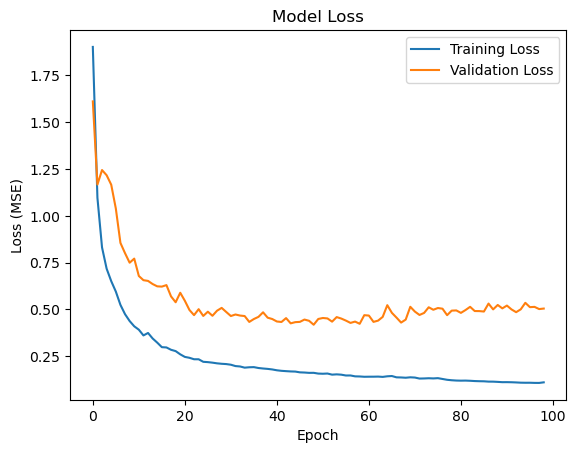

In [22]:

# multihead model loss
# Plot loss and validation loss
# model2_history.keys()
# plt.plot(model2_history['loss'])

plt.plot(model2_history['loss'], label="Training Loss")
plt.plot(model2_history['val_loss'], label ="Validation Loss")
# plt.plot(model2_history.history['dense_26_loss'], label ="Head 1 Train Loss")
# plt.plot(model2_history.history['dense_27_loss'], label ="Head 2 Train Loss")
# plt.plot(model2_history.history['val_dense_26_loss'], label ="Head 1 Val. Loss")
# plt.plot(model2_history.history['val_dense_27_loss'], label ="Head 2 Val. Loss")

print("Best Epoch (Model restored from this eopch)", np.argmin(model2_history['val_loss'])+1,
      "Early Stopping Kicked in at Epoch", np.argmin(model2_history['val_loss'])+1 + 50)


plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.savefig("ModelLoss_LSTM2_v1.png", dpi=300)
# plt.show()